# Crop Rotation
In this assignment you need to do the following:
1. Clip the 2016 and 2017 CDL rasters to the state of Illinois.
2. Summarize the top 10 land uses in Illinois in each year.
3. Create two rasters for each year:
    - 1 if pixel is corn, 0 otherwise
    - 1 if pizel is soybeans, 0 otherwise
    
    And then plot them.
4. Describe the degree of crop rotation (corn and soybeans only) between 2016 and 2017.
5. Create a raster using the CDL layers where each pixel is labeled:
    - 1 = corn stayed corn
    - 2 = soybeans stayed soybeans
    - 3 = corn changed to soybeans
    - 4 = soybeans changed to corn
    - 0 = any other case.
    
6. Visualize the raster on top of the Illinois shapefile.
7. Suppose a client has the following question:
    
    __"What are the crop yield advantages of crop rotation as compared to monocropping in Illinois?"__
   
   Describe how you might answer this question using the CDL layer, specifically:
       - What data sources you would need in addition to the raster you just created.
       - How you would manipulate the data.
       - What statistics you would calculate or model you would run on this data.
       - How you might present your findings.
8. What factors would make it difficult to accurately answer the question? List three and explain why they might make answering the question difficult.

### The Import Line

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors

from scipy.signal import medfilt2d

## 1. Clip Rasters

Read them in:

In [2]:
cdl_17 = rasterio.open("../Data/Images/CDL_2017_clip_20201204121126_1861392834/CDL_2017_clip_20201204121126_1861392834.tif")
cdl_16 = rasterio.open("../Data/Images/CDL_2016_clip_20201204145427_1867782208/CDL_2016_clip_20201204145427_1867782208.tif")

Create a dictionary (just for FUN)

In [3]:
cdls = {16:cdl_16,17:cdl_17}

State shape file (actually a geojson file)

In [4]:
state_file = "..//Data/Images/gz_2010_us_040_00_5m.json"

country = geopandas.read_file(state_file)

### ahh, but did you remember to check the projection??

In [5]:
cdl_17.crs == country.crs

False

They are not the same! So easiest thing is just to reproject the vector file to the raster's CRS

In [6]:
# Reproject
country = country.to_crs(cdl_16.crs)

Want just Continental US

In [7]:
country = country[(country.NAME!="Alaska")&\
                  (country.NAME!="Hawaii")&\
                  (country.NAME!="Puerto Rico")]

<AxesSubplot:>

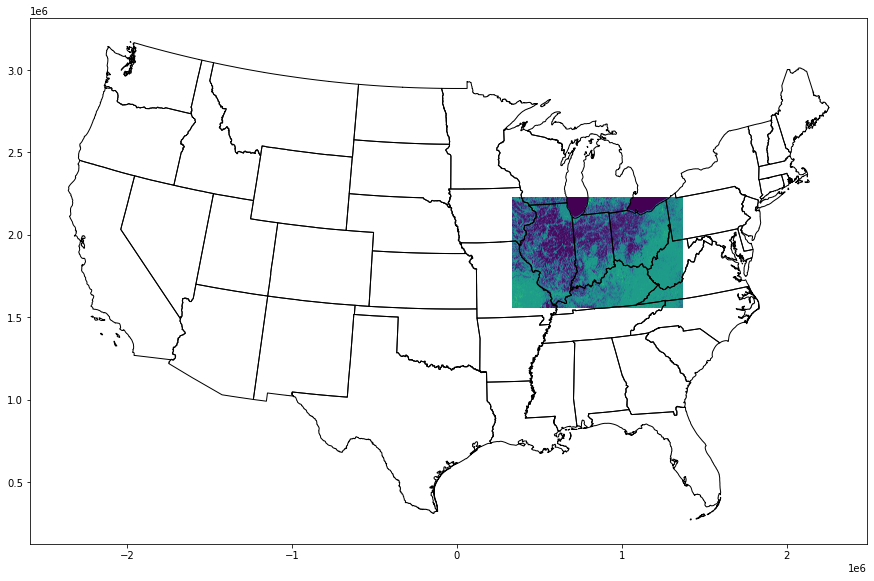

In [8]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(cdl_16, ax=ax)
country.plot(ax=ax, facecolor='none', edgecolor='black')

So we have a small window over Illinois, Indiana, and Ohio.

We just want Illinois, so we can do some clipping.

In [9]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [10]:
IL_coords = getFeatures(country[(country["NAME"] == "Illinois")])

coords = \
{"IL": IL_coords}

img_out, img_transform = mask(cdl_16,IL_coords) 


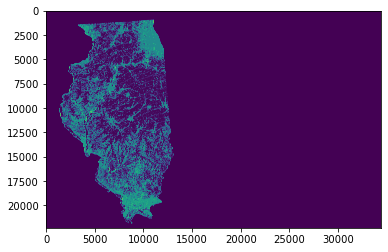

In [11]:
plt.imshow(img_out[0,:,:])

To save space, I'm actually going to cut off the right side of this raster

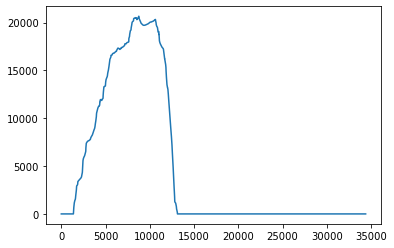

In [12]:
plt.plot((img_out[0,:,:]!=0).sum(axis=0))

The non-zero pixels are basically to the left of 15k.

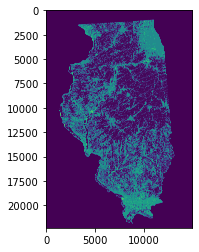

In [13]:
plt.imshow(img_out[0,:,:15000])

Good enough:

In [14]:
for year,cdl in cdls.items():
    for k,v in coords.items():
        # Transform with the mask
        img_out, img_transform = mask(cdl,v) 
        
        # Cut out the right side of the image.
        img_out = img_out[:,:,:15000]
        
        # Metadata
        out_meta = cdl.meta.copy()
        out_meta['height'] = img_out.shape[1]
        out_meta['width'] = img_out.shape[2]
        out_meta['transform'] = img_transform
        
        # This field will tell you which pixel values mean "no data" and thus are transparent.
        out_meta['nodata'] = 0
        
        with rasterio.open("./raster_"+k+"_"+str(year)+".tif", "w", **out_meta) as dest:
            dest.write(img_out)

Now let's see if we did it right

In [15]:
IL_16 = rasterio.open("./raster_IL_16.tif")

<AxesSubplot:>

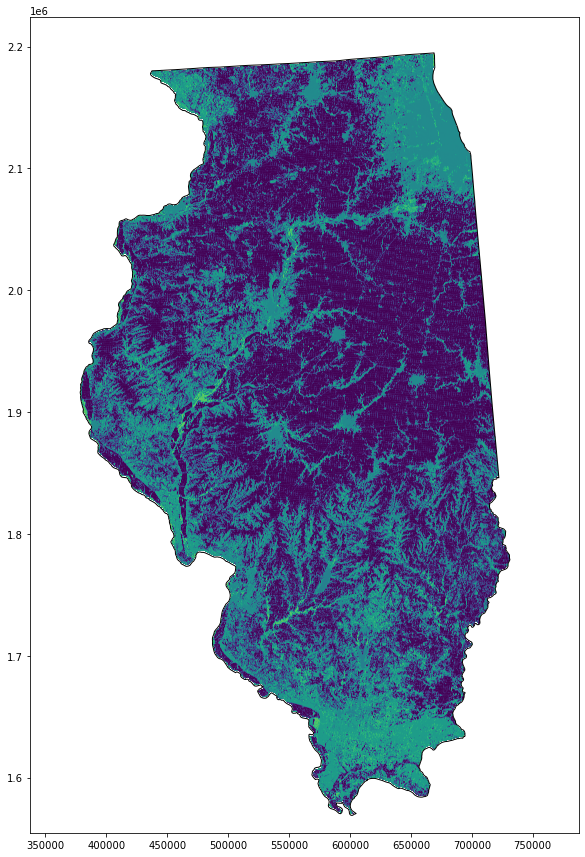

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(IL_16, ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')

Things are missing from the edged because they are zero values, or "background" according to the CDL documentation/

## 2. Top 10 Land Uses in Each Year

To find the names for the pixels, I made a dictionary (json file) from the CDL documentation.

In [17]:
with open("../Data/Images/CDL_dict.json") as f:
    pixel_names = json.load(f)[0]

Now we store all the rasters in one dictionary:

In [18]:
rasters = {}
for year in cdls.keys():
    rasters[year] = {}
    for state in coords.keys():
        rasters[year][state] = rasterio.open("./raster_"+state+"_"+str(year)+".tif")

Here is a function that listes the top uses by year:

In [19]:
def top_uses(state,year,number):
    # Read the first band of the raster
    the_array = rasters[year][state].read(1)
    
    # Flatten it into one array
    flattened_array = the_array.flatten()
    
    # Take out the zeros
    all_uses = flattened_array[flattened_array!=0]
    
    # Here I'm using the value counts function, 
    # and also "normalize" so it gives me a percentage
    top_uses = pd.Series(all_uses).value_counts(normalize=True).head(number)*100
    
    # Rename the index using the dictionary
    top_uses.index = pd.Series(top_uses.index).astype(str).replace(pixel_names)
    
    # Spit it back out
    return top_uses

In [20]:
IL10_16 = top_uses("IL",16,10)
IL10_17 = top_uses("IL",17,10)

top_10_uses = pd.concat([IL10_16,IL10_17],axis=1)
top_10_uses.columns = ["2016","2017"]

top_10_uses

,2016,2017
Corn,31.824279,31.073792
Soybeans,26.555607,27.692358
Deciduous Forest,15.784611,15.751903
Grassland/Pasture,8.876067,8.744953
Developed/Low Intensity,4.723651,4.713068
Developed/Open Space,4.528436,4.502031
Open Water,1.790056,1.789315
Developed/Med Intensity,1.647152,1.656829
Woody Wetlands,1.140620,1.150148
Dbl Crop WinWht/Soybeans,0.898216,0.797799


So above the tables are in units of percentage of land each year.

Mostly just corn, soybeans, and forest.

## 3. Making Crop Rasters

Here I wrote a function that does the write and transform tasks necessary to transform and array into a raster.

In [21]:
def recode_raster_binary(raster,array,img_transform,name):
    out_meta = raster.meta.copy()
    array = array[np.newaxis,:,:]
    out_meta['height'] = array.shape[1]
    out_meta['width'] = array.shape[2]
    out_meta['transform'] = img_transform
    
    with rasterio.open(name, "w", **out_meta) as dest:
        dest.write(array.astype(rasterio.uint8)) # Notice here it codes "uint8" because thats all we need for binary data

Using the documentation, we know that these are the two codes for corn and soybeans:

In [22]:
crop_labels = {1:"corn",5:"soybeans"}

Below is a nested for loop that creates a nested dictionary with these rasters:

In [23]:
crop_rasters = {}

# For each state
for state in coords.keys():
    crop_rasters[state] = {}
    # For each CDL year:
    for year in cdls.keys():
        crop_rasters[state][year] = {}
        # For each crop:
        for val,crop in crop_labels.items():
            # Read in the band and make a binary array:
            array = (rasters[year][state].read(1)==val).astype(np.int8)
            
            # Write it out using our function
            recode_raster_binary(cdl,array,img_transform,"./raster_"+state+"_"+str(year)+"_"+crop+".tif")

            # Store it in this dictionary:
            crop_rasters[state][year][crop] = rasterio.open("./raster_"+state+"_"+str(year)+"_"+crop+".tif")

Now plot it:

In [24]:
# Imma make some colormaps first:

cmap_beans = matplotlib.colors.ListedColormap(['white',"C0"])
cmap_corn = matplotlib.colors.ListedColormap(['white',"darkgreen"])

<AxesSubplot:title={'center':'Soybean Area, 2017'}>

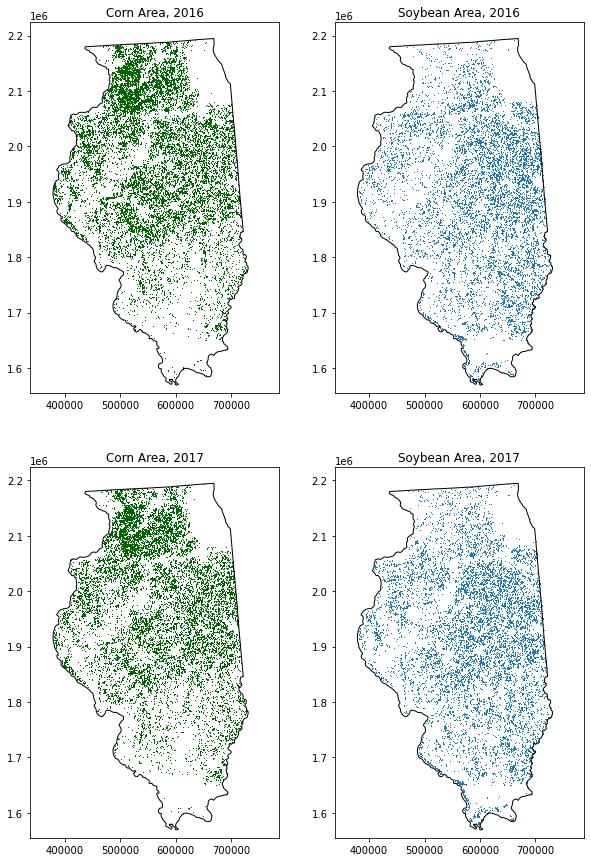

In [25]:
fig, ax = plt.subplots(2,2,figsize=(10, 15))

# Corn 2016
rasterio.plot.show(crop_rasters["IL"][16]["corn"], ax=ax[0,0],cmap=cmap_corn)
ax[0,0].set_title("Corn Area, 2016")
country[country['NAME']=="Illinois"].plot(ax=ax[0,0], facecolor='none', edgecolor='black')

# Soybeans 2016
rasterio.plot.show(crop_rasters["IL"][16]["soybeans"], ax=ax[0,1],cmap=cmap_beans)
ax[0,1].set_title("Soybean Area, 2016")
country[country['NAME']=="Illinois"].plot(ax=ax[0,1], facecolor='none', edgecolor='black')

# Corn 2017
rasterio.plot.show(crop_rasters["IL"][17]["corn"], ax=ax[1,0],cmap=cmap_corn)
ax[1,0].set_title("Corn Area, 2017")
country[country['NAME']=="Illinois"].plot(ax=ax[1,0], facecolor='none', edgecolor='black')

# Soybeans 2017
rasterio.plot.show(crop_rasters["IL"][17]["soybeans"], ax=ax[1,1],cmap=cmap_beans)
ax[1,1].set_title("Soybean Area, 2017")
country[country['NAME']=="Illinois"].plot(ax=ax[1,1], facecolor='none', edgecolor='black')

## 4. How often did crops rotate?

What we want to know is how often a pixel changed from being a 1 to a 5 and vice versa, and also how often did it stay the same.

There are two ways to do this:
- the REALLY LONG way: go through each index and assign a 1 or a 2 to anything monocropped or rotated.
- the matrix way: Make a boolean matrix of the desired condition, multiply it by that value, and add all the matrices together.

In [26]:
# Its very useful to make matrices like this that are three dimensions.
IL_17 = np.concatenate([rasterio.open("./raster_IL_17_corn.tif").read(1)[np.newaxis,:,:],
                        rasterio.open("./raster_IL_17_soybeans.tif").read(1)[np.newaxis,:,:]],axis=0)

IL_16 = np.concatenate([rasterio.open("./raster_IL_16_corn.tif").read(1)[np.newaxis,:,:],
                        rasterio.open("./raster_IL_16_soybeans.tif").read(1)[np.newaxis,:,:]],axis=0)

In [27]:
# Assign a one to anything monocropped
corn_to_corn = ((IL_17[0,:,:]==1)&(IL_16[0,:,:]==1))*1
beans_to_beans = ((IL_17[1,:,:]==1)&(IL_16[1,:,:]==1))*1

# Assign a two to anything that rotated
beans_to_corn = ((IL_17[0,:,:]==1)&(IL_16[1,:,:]==1))*2
corn_to_beans = ((IL_17[1,:,:]==1)&(IL_16[0,:,:]==1))*2

Assuming all these categories are mutually exclusive, we can just add them all together:

In [28]:
Rotated = corn_to_corn + beans_to_beans + beans_to_corn + corn_to_beans

So what percent of the pixels were rotated between corn and soybeans?

In [29]:
rotated_pixels = pd.Series(Rotated.flatten())

In [30]:
rotated_pixels[rotated_pixels!=0].value_counts(normalize=True)*100

2    78.840051
1    21.159949
dtype: float64

Nearly 80% of soybeans and corn is rotated between the two.

Visualizing what we just created:

In [31]:
# First put it in a raster format:
recode_raster_binary(cdl_16,Rotated,img_transform,"./raster_IL_rotation.tif")

Rotated_Raster = rasterio.open("./raster_IL_rotation.tif")

Next make a colormap:

In [32]:
labels = {1:"Non-Rotated",
          2:"Rotated"}

cmap = matplotlib.colors.ListedColormap(['white', "C3","C0"])

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]

Now plot them together

(337545.0, 787545.0, 1554765.0, 2223945.0)

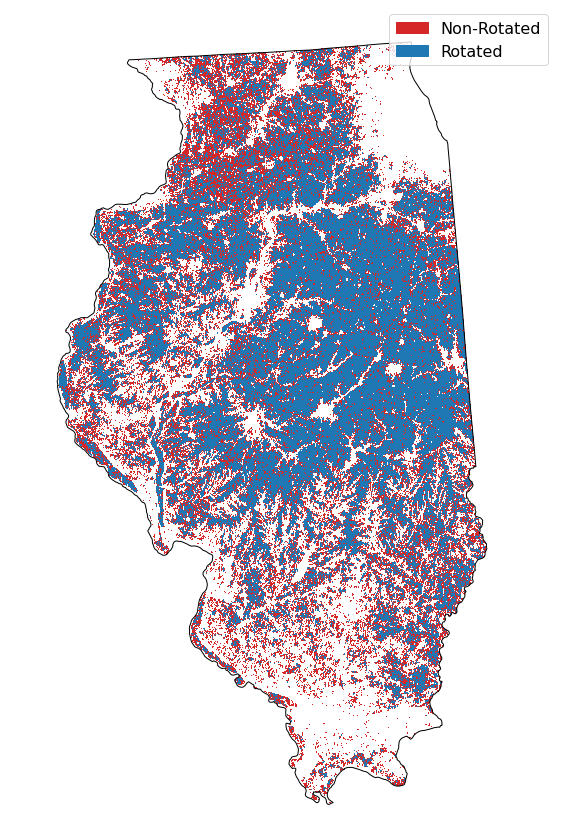

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(Rotated_Raster,cmap=cmap,ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')
plt.legend(handles=patches,fontsize=16)
plt.axis('off')

## 5. Crop Rotation Raster

In [34]:
# As before:
corn_to_corn = ((IL_17[0,:,:]==1)&(IL_16[0,:,:]==1))*1
beans_to_beans = ((IL_17[1,:,:]==1)&(IL_16[1,:,:]==1))*2
beans_to_corn = ((IL_17[0,:,:]==1)&(IL_16[1,:,:]==1))*3
corn_to_beans = ((IL_17[1,:,:]==1)&(IL_16[0,:,:]==1))*4

In [35]:
Rotated_Cats = corn_to_corn + beans_to_beans + beans_to_corn + corn_to_beans

__FYI: the long, for loop way would be:__

In [36]:
for i in range(Rotation.shape[0]):
    for j in range(Rotation.shape[1]):
        if (IL_17[0,i,j]==1)&(IL_16[0,i,j]==1):
            Rotation[i,j] = 1
        elif (IL_17[1,i,j]==1)&(IL_16[1,i,j]==1):
            Rotation[i,j] = 2
        elif (IL_17[0,i,j]==1)&(IL_16[1,i,j]==1):
            Rotation[i,j] = 3
        elif (IL_17[1,i,j]==1)&(IL_16[0,i,j]==1):
            Rotation[i,j] = 4

NameError: name 'Rotation' is not defined

__Dont run this code unless you want your computer to busy for days.__

Writing out the array in a raster format:

In [ ]:
recode_raster_binary(cdl_16,Rotated_Cats,img_transform,"./raster_IL_rotation_cats.tif")

Rotated_Cat_Raster = rasterio.open("./raster_IL_rotation_cats.tif")

## 6. Visualizing the Crop Rotation Raster

In [ ]:
cmap = matplotlib.colors.ListedColormap(['white', "lightcoral","firebrick", 'C2', 'C0'])

labels = {1:"Corn to Corn",
          2:"Beans to Beans",
          3:"Beans to Corn",
          4:"Corn to Beans"}

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]


In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(Rotated_Cat_Raster,cmap=cmap,ax=ax)
country[country['NAME']=="Illinois"].plot(ax=ax, facecolor='none', edgecolor='black')
plt.legend(handles=patches,fontsize=12,loc=(0,.8))
plt.axis('off')

In table form:

In [ ]:
Rotated_Series = pd.Series(Rotated_Cats.flatten())

top_transitions = Rotated_Series[Rotated_Series!=0].value_counts(normalize=True)*100

labels = {"1":"Corn to Corn",
          "2":"Beans to Beans",
          "3":"Beans to Corn",
          "4":"Corn to Beans"}

top_transitions.index = pd.Series(top_transitions.index).astype(str).replace(labels)

top_transitions

Not surprisingly, crop rotation is equally split between corb and beans (nearly). About 20\% of pixels did not rotate, mostly in the North or South of the state.

## 7. The Effect of Crop Rotation on Yield

This is essentially a causal inference question, so its very difficult to answer. To be able to get close to answering it, you would at least need the following __additional__ data sources:
- Crop yield (per county, most likely from the Ag Census).
- Weather data (available from PRISM).
- Data on inputs (also probably from the Census).

To get the same level of analysis takes even more effort. One plan of action could be:
1. Summarize the crop rotation data to the county level using zonal statistics and a county shapefile.
     a. Example: what percentage of crop acres in each county was rotated?
2. Do the same for the PRISM data.
3. Merge in county level yield and input data from the 2017 ag census.
4. Estimate a production function on this cross-section for each crop:
$$ Yield_{i} = \beta Rotated_{i} + \gamma Inputs_{i} + \delta Weather_{i} + \epsilon_i $$


Which identifies the yield advantage as $\beta$, __conditional on the assumption:__ 

 $$E(Rotated_i \epsilon_i) =0$$.
 
## 8. When is this assumption violated?
So given this regression:
$$ Yield_{i} = \beta Rotated_{i} + \gamma Inputs_{i} + \delta Weather_{i} + \epsilon_i $$

$\beta$ is __unbiased, conditional on the assumption__ $E(Rotated_i \epsilon_i) =0$.

 Why might this assumption be violated? Let's think about the DGP:
 
 A farmer with corn will rotate to soybeans if:
 
 $$ ExpectedProfit(Soybeans,X_i,\epsilon_S) > ExpectedProfit(Corn,X,W,\epsilon_C)$$ 
 
 and vice versa for a farmer that planted soybeans. The thing we should be curious about is what the unknown factors, $\epsilon$, are for the choice of each crop. Some possibilities:
 1. Some of it might be the unobserved inputs or skills that the farmers use have not been measured in the county level census. Mundlauk would call this "management bias," and fixed it using fixed effects (pun not intended). In our case with more years of data we could try a county fixed effect.
 2. Prices are not in this regression, which may be a huge problem. All production functions need output/input prices!
 3. Soil quality: their choice of crops could be determined by their soil types.
 4. Dynamic bias: crop rotation puts nitrogen back in the soil, which has benefits down the line. Not taking the future benefits into account can result in a misspecified regression.